In this part, the data from GSE55763 will be imported, quality-checked, and structured to facilitate downstream analysis.

In [2]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [56]:
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

In [64]:
gse = GEOparse.get_GEO(geo="GSE55763", destdir="./data", silent=True, how="full")

C:\Users\Owner\anaconda3\Lib\site-packages\GEOparse\GEOparse.py:401: DtypeWarning: Columns (11,14,15,36) have mixed types. Specify dtype option on import or set low_memory=False.
  return read_csv(StringIO(data), index_col=None, sep="\t")


In [65]:
print(list(gse.gsms.keys())[:3])

['GSM1343050', 'GSM1343051', 'GSM1343052']


In this case, GSM1343050, GSM1343051, GSM1343052 are sample IDs.

In [67]:
print("The number of samples is:", len(gse.gsms))

The number of samples is: 2711


Explore the metadata in GSE55763

In [69]:
metadata = {}
for gsm_name, gsm in gse.gsms.items():
    for key, value in gsm.metadata.items():
        if key == 'characteristics_ch1':
            tmpVal = 0
            for tmp in value:
                splitUp = [i.strip() for i in tmp.split(':')]
                if len(splitUp) == 2:
                    if not splitUp[0] in metadata:
                        metadata[splitUp[0]] = {}
                    metadata[splitUp[0]][gsm_name] = splitUp[1]


In [82]:
df_metadata = pd.DataFrame(metadata)

In [84]:
df_metadata = df_metadata.transpose() ## Transpose the DataFrame so that samples are rows and metadata fields are columns

In [86]:
print(df_metadata.head(3))   # display the first 3 rows

                                            GSM1343050  \
tissue                                peripheral blood   
dataset  population study; technical replication study   
gender                                               M   

                                            GSM1343051  \
tissue                                peripheral blood   
dataset  population study; technical replication study   
gender                                               M   

                                            GSM1343052  \
tissue                                peripheral blood   
dataset  population study; technical replication study   
gender                                               M   

                          GSM1343053                   GSM1343054  \
tissue              peripheral blood             peripheral blood   
dataset  technical replication study  technical replication study   
gender                             M                            M   

                        

In [88]:
print(df_metadata.columns)

Index(['GSM1343050', 'GSM1343051', 'GSM1343052', 'GSM1343053', 'GSM1343054',
       'GSM1343055', 'GSM1343056', 'GSM1343057', 'GSM1343058', 'GSM1343059',
       ...
       'GSM1345751', 'GSM1345752', 'GSM1345753', 'GSM1345754', 'GSM1345755',
       'GSM1345756', 'GSM1345757', 'GSM1345758', 'GSM1345759', 'GSM1345760'],
      dtype='object', length=2711)


In [94]:
# Transpose so samples become rows
df_metadata = df_metadata.set_index("gsm").transpose()

# Reset index so GSM IDs are a column
df_metadata.reset_index(inplace=True)
df_metadata.rename(columns={"index": "gsm"}, inplace=True)

# Rename columns to something clean
df_metadata.rename(columns={
    "gender": "sex",
    "tissue": "tissue",
    "age": "age"
}, inplace=True)

# Convert age to numeric
df_metadata["age"] = pd.to_numeric(df_metadata["age"], errors="coerce")

print(df_metadata.head())
print(df_metadata.dtypes)


gsm         gsm            tissue  \
0    GSM1343050  peripheral blood   
1    GSM1343051  peripheral blood   
2    GSM1343052  peripheral blood   
3    GSM1343053  peripheral blood   
4    GSM1343054  peripheral blood   

gsm                                        dataset sex   age  
0    population study; technical replication study   M  57.9  
1    population study; technical replication study   M  42.0  
2    population study; technical replication study   M  47.4  
3                      technical replication study   M  49.3  
4                      technical replication study   M  52.5  
gsm
gsm         object
tissue      object
dataset     object
sex         object
age        float64
dtype: object


Filter human samples with complete metadata

In [157]:
# Keep only samples with age and sex
df_filtered = df_metadata.dropna(subset=['age', 'sex'])

# Filter human samples based on tissue keywords
human_keywords = ['human', 'Homo sapiens', 'blood', 'peripheral blood', 'PBMC', 'whole blood']
mask_human = df_filtered['tissue'].str.contains('|'.join(human_keywords), case=False, na=False)
df_filtered = df_filtered[mask_human]

# Keep population study samples; include technical replicates only if part of population study
mask_population = ~df_filtered['dataset'].str.contains('technical replication', case=False, na=False) | df_filtered['dataset'].str.contains('population study', case=False, na=False)
df_filtered = df_filtered[mask_population]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

print(f"Number of human samples after filtering: {df_filtered.shape[0]}")


Number of human samples after filtering: 2664


In [155]:
# Step 1: Keep samples with age and sex
df_filtered = df_metadata.dropna(subset=['age', 'sex'])

# Step 2: Keep only human samples
human_keywords = ['human', 'Homo sapiens', 'blood', 'peripheral blood', 'PBMC', 'whole blood']
mask_human = df_filtered['tissue'].str.contains('|'.join(human_keywords), case=False, na=False)
df_filtered = df_filtered[mask_human]

# Step 3 (optional): keep technical replicates from population study
mask_population = ~df_filtered['dataset'].str.contains('technical replication', case=False, na=False) | df_filtered['dataset'].str.contains('population study', case=False, na=False)
df_filtered = df_filtered[mask_population]

# Step 4: Reset index
df_filtered = df_filtered.reset_index(drop=True)

# Step 5: Check number of samples
print(f"Number of human samples after filtering: {df_filtered.shape[0]}")


Number of human samples after filtering: 2664


In [159]:
df_metadata['age'] = pd.to_numeric(df_metadata['age'], errors='coerce') # convert to numeric for further analysis
print(df_metadata['age'].describe().round(2)) # Summary statistics and round to 2 digits

count    2711.00
mean       51.02
std        10.09
min        23.70
25%        43.20
50%        50.20
75%        57.60
max        75.00
Name: age, dtype: float64


In [161]:
print("Median age:", df_metadata['age'].median()) # Calculate the median
print("Mode age:", df_metadata['age'].mode().to_list()) #Calculate a mode and store its a list

Median age: 50.2
Mode age: [35.1, 35.2]


In [163]:
display(df_metadata['dataset'].value_counts())

dataset
population study                                 2639
technical replication study                        47
population study; technical replication study      25
Name: count, dtype: int64

Data visualization

The variable age is represented using a histogram, which displays the distribution of ages across all samples in the dataset.

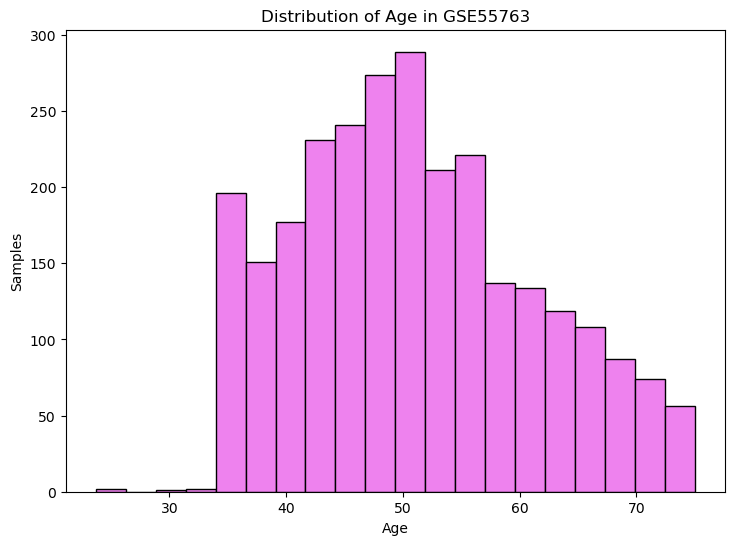

In [167]:
plt.figure(figsize=(8.5, 6))
plt.hist(df_metadata['age'], bins=20, color='violet', edgecolor='black')
plt.title('Distribution of Age in GSE55763')
plt.xlabel('Age')
plt.ylabel('Samples')
plt.show()

An alternative way to visualize this variable is with a density plot, which shows the distribution and relative frequency of values across the dataset.

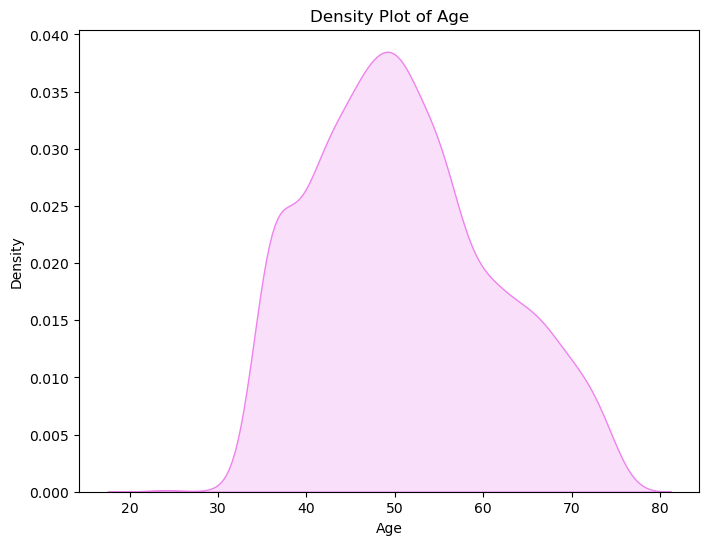

In [170]:
plt.figure(figsize=(8,6))
sns.kdeplot(df_metadata['age'], fill=True, color='violet')
plt.title('Density Plot of Age')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

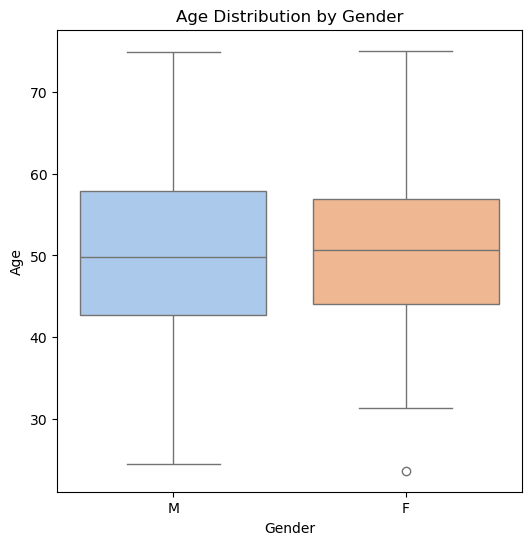

In [180]:
plt.figure(figsize=(6,6))
sns.boxplot(x='sex', y='age', hue='sex', data=df_filtered, palette='pastel', dodge=False, legend=False)
plt.title("Age Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Age")
plt.show()


In [184]:
gender_table = pd.DataFrame({
    'Count': df_filtered['sex'].value_counts(),
    'Percentage (%)': (df_filtered['sex'].value_counts(normalize=True) * 100).round(1)
})

display(gender_table)


,Count,Percentage (%)
sex,,
M,1805,67.8
F,859,32.2


For the variable gender, which is categorical, the distribution is visualized using a bar plot.

Verification of Gender as a Categorical Variable

In [186]:
print(df_metadata['sex'].unique())


['M' 'F']


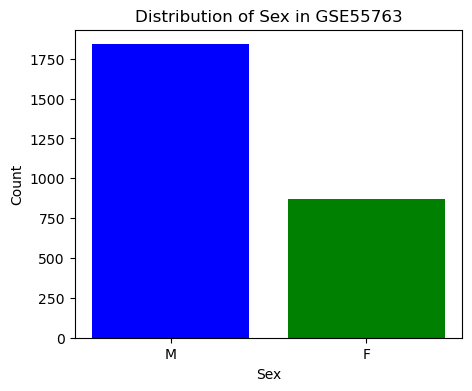

In [204]:
# Count the number of males and females
gender_table = df_metadata['sex'].value_counts().reset_index()
gender_table.columns = ['Sex', 'Count']

# Plot
plt.figure(figsize=(5,4))
plt.bar(gender_table['Sex'], gender_table['Count'], color=['blue', 'green'])
plt.title("Distribution of Sex in GSE55763")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

Outlier analysis is performed on the age variable to identify extreme values that could influence downstream analyses. Outliers are defined using the interquartile range (IQR) method, where values below Q1 − 1.5×IQR or above Q3 + 1.5×IQR are considered outliers

In [191]:
age = df_metadata['age'].dropna()  # ignore missing values

Q1 = np.percentile(age, 25)
Q3 = np.percentile(age, 75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = age[(age < lower) | (age > upper)]

print(f"Lower bound: {lower:.2f}, Upper bound: {upper:.2f}")
print("Outliers:", outliers.values)

Lower bound: 21.60, Upper bound: 79.20
Outliers: []


Extract beta-values

Cohort summary table

In [200]:
cohort_summary = pd.DataFrame({
    "Total Samples": [len(df_filtered)],
    "Mean Age": [df_filtered["age"].mean().round(2)],
    "Median Age": [df_filtered["age"].median()],
    "Min Age": [df_filtered["age"].min()],
    "Max Age": [df_filtered["age"].max()],
    "Male Count": [sum(df_filtered["sex"] == "M")],
    "Female Count": [sum(df_filtered["sex"] == "F")]
})

cohort_summary



,Total Samples,Mean Age,Median Age,Min Age,Max Age,Male Count,Female Count
0,2664,50.95,50.1,23.7,75.0,1805,859
